## This analysis classifies genes according to their response to three different mechanical stimulations: PS, OS, or LF flow patterns and then delineate a SARS-CoV-2 interactome

In [1]:
options(warn=-1)

homedir <- "C:/Users/breng/Desktop/final shear analysis"
funcsfile <- "shear_analysis_functions.r"

fdrname <- "./data/4 edgeR.xls"
fcanalyzed <- "./data/6 PSLFOSLF FC data.xls"
coviddb <- "./data/COVID_data/binding protein list.csv"
cytofile <- "./data/cytoscape/cytoscape_interactions.csv"
klf4seq <- "./data/2 A2B1_pvalue KLF4_over.csv"

setwd(homedir)
source(funcsfile)

suppressMessages({
    library(ggplot2)
    library(ggpubr)
    library(data.table)
    library(matrixStats)
    library(pheatmap)
    library(heatmaply)
    library(VennDiagram)
    library(ClinicalDataMineR)
    library(ConservationtextmineR)
    library(dplyr)
    library(fmsb)
    library(biomaRt)
    library(systemPipeR)
    library(Rsamtools)
    library(GenomicAlignments)
    library(rtracklayer)
    library(gridExtra)
    library(MyPackage)
    library(Gviz)
    library(rtracklayer)
    library(trackViewer)
    library(RColorBrewer)  
})

The file "4 edgeR" contains the computed fold changes from a 10 time point RNAseq experiment involving endothelial cells subjected to PS, OS, or LF.

The file "6 PSLFOSLF FC data" contains the complete cases of file 4 in addition to the gene name annotation information and the raw read counts.

In [2]:
dt1 <- fread(fdrname)
dt1 <- dt1[,!grep("(logCPM|LR)", colnames(dt1)), with = FALSE]; setkey(dt1, TranscriptID)
annotation <- fread(fcanalyzed)
annotation <- annotation[,grep("(Transcrip|Name|setA|setB)", colnames(annotation)), with = FALSE]; setkey(annotation, TranscriptID)
#dt <- merge(dt1, annotation, by = "TranscriptID")
dt <- dt1[annotation]
dt <- fread("./results/1 shear_scored_flow_responsive_annotated.xls")
str(dt)

Classes 'data.table' and 'data.frame':	20450 obs. of  138 variables:
 $ GeneName          : chr  "PTGS2" "HES1" "SDPR" "SMAD6" ...
 $ PS1-LF_logFC      : num  0.41 -0.475 -0.459 0.794 0.324 ...
 $ PS1-LF_PValue     : num  0.18628 0.01503 0.00413 0.02607 0.14708 ...
 $ PS1-LF_FDR        : num  1 1 1 1 1 ...
 $ PS2-LF_logFC      : num  1.83 -2.17 -1.13 1.53 1.11 ...
 $ PS2-LF_PValue     : num  4.97e-11 1.63e-17 4.87e-10 1.19e-06 1.92e-08 ...
 $ PS2-LF_FDR        : num  1.69e-07 3.34e-13 1.25e-06 1.63e-03 3.57e-05 ...
 $ PS3-LF_logFC      : num  2.12 -1.48 -2.07 1.52 1.4 ...
 $ PS3-LF_PValue     : num  1.15e-14 1.05e-10 3.11e-22 1.77e-06 1.77e-13 ...
 $ PS3-LF_FDR        : num  4.71e-11 1.27e-07 6.36e-18 6.82e-04 4.52e-10 ...
 $ PS4-LF_logFC      : num  1.71 -1.03 -2.44 1.65 1.28 ...
 $ PS4-LF_PValue     : num  1.10e-09 1.66e-06 6.68e-27 9.78e-08 3.07e-11 ...
 $ PS4-LF_FDR        : num  9.40e-07 5.66e-04 1.37e-22 5.00e-05 3.92e-08 ...
 $ PS6-LF_logFC      : num  2.132 -0.987 -2.911 1.956 

Generate graphs of Genes that are sensitive to Pulsatile Shear/Oscillatory Shear and genes that respond to shear independent of pattern.

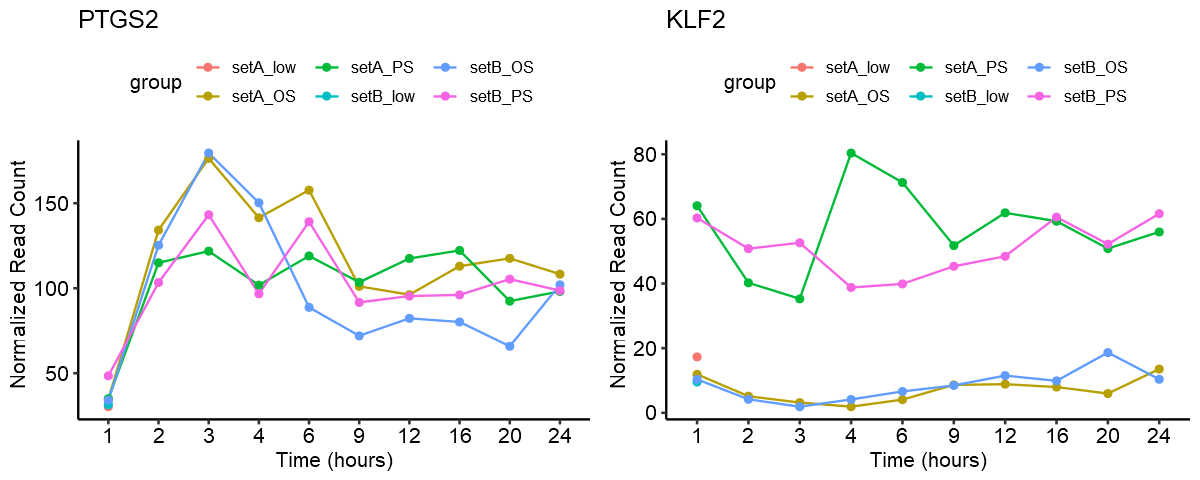

In [3]:
options(repr.plot.width=10, repr.plot.height=4)
p1 <- grapher(dt[1,c(1,93:134), with = FALSE])
p2 <- grapher(dt[order(dt$FDRscore_PSOS),][1,c(1,93:134), with = FALSE])
grid.arrange(p1, p2, nrow = 1)

#### Generate a line graphs of the raw read values of the shear responsive PSOS responsive genes

In [4]:
#### plot all genes according to ranking in a loop ####
dir.create("./results/1_shear_responsive"); dir.create("./results/1_PSOS_responsive"); dir.create("./results/1_shear_and_PSOS_responsive")
lineGraph_loopR(DataTable = dt[(shear_responsive == "pattern_independent") & (!PSOS_responsive == "PSOS"),], directory = "./results/1_shear_responsive/", columns = c(1,93:134))
lineGraph_loopR(DataTable = dt[order(dt$FDRscore_PSOS),][(!shear_responsive == "pattern_independent") & (PSOS_responsive == "PSOS"),], directory = "./results/1_PSOS_responsive/", columns = c(1,93:134))
lineGraph_loopR(DataTable = dt[(shear_responsive == "pattern_independent") & (PSOS_responsive == "PSOS"),], directory = "./results/1_shear_and_PSOS_responsive/", columns = c(1,93:134))

# Section I Explore which human proteins that interact with SARS-CoV-2 proteins are shear or PSOS responsive.

The SARS-CoV-2 gene interactions were downloaded from: http://geneontology.org/covid-19.html

#### Annotate database of shear and PSOS responsive genes with the SARS-CoV-2 interacting proteins

In [5]:
binding <- fread(coviddb)
entry <- c("ACE2", "TMPRSS2") #### Human proteins involved in viral entry ####
#### Annotate according to which genes are COVID-19 binding proteins ####
dt$COVID_interaction <- "NA"
dt[(toupper(dt$GeneName) %in% toupper(c(binding$PreyGene, entry))),]$COVID_interaction <- "COVID_interactor"
final_covid <- dt
#### polish genes that were called incorrectly ####
shear_rm <- c("PPT1", "CHMP2A", "PSMD8", "ITGB1", "MAP7D1", "NUFB9") #### Genes to remove from shear dataset
psos_rm <- c("EIF4H", "SLC44A2") #### Genes to remove from psos dataset
psos_to_shear <- c("GDF15") #### Genes to move freom psos dataset to shear dataset # "FBLN5",
#### remove genes ####
final_covid[(final_covid$GeneName %in% shear_rm),]$shear_responsive <- "NA"
final_covid[(final_covid$GeneName %in% psos_rm),]$PSOS_responsive <- "NA"
#### move genes to proper datatable ####
final_covid[final_covid$GeneName == psos_to_shear[1] | final_covid$GeneName == psos_to_shear[2],]$PSOS_responsive <- "NA"
final_covid[final_covid$GeneName == psos_to_shear[1] | final_covid$GeneName == psos_to_shear[2],]$shear_responsive <- "pattern_independent"
# writab(DT=final_covid, fname="./results/2 COVID annotated data table.xls")

#### Subset out genes that are shear or PSOS responsive and interact with a SARS-CoV-2 protein

In [9]:
#### pull out COVID-19 interacting proteins ####
covid <- final_covid[final_covid$COVID_interaction == "COVID_interactor",]
#### separate into PSOS or shear responsive ####
covid_shear <- covid[covid$shear_responsive == "pattern_independent",]
covid_psos <- covid[covid$PSOS_responsive == "PSOS",]
#### remove duplications ####
covid_sheardup <-covid_shear[covid_shear[, .I[which.min(`FDRscore_shear`)], by=GeneName]$V1]
covid_psosdup <-covid_psos[covid_psos[, .I[which.min(`FDRscore_PSOS`)], by=GeneName]$V1]
#### overlapping genes ####
intersect(covid_sheardup$GeneName, covid_psosdup$GeneName)
#covid[covid$GeneName == intersect(covid_sheardup$GeneName, covid_psosdup$GeneName),]
covid <- rbind(covid_sheardup, covid_psosdup)
#### annotate with the name of the protein each gene interacts with ####
bindingsub <- binding[,(colnames(binding) %in% c("Bait", "PreyGene", "Uniprot Function", "Uniprot Function in Disease")), with = FALSE]
colnames(bindingsub)[2] <- "GeneName"
covid <- merge(covid, bindingsub, by = "GeneName")
# writab(DT=covid, fname="./results/3 final COVID only data table.xls")

character(0)

#### Heatmap of the fold changes of the flow PSOS and flow independent genes that interact with SARS-CoV-2 proteins.

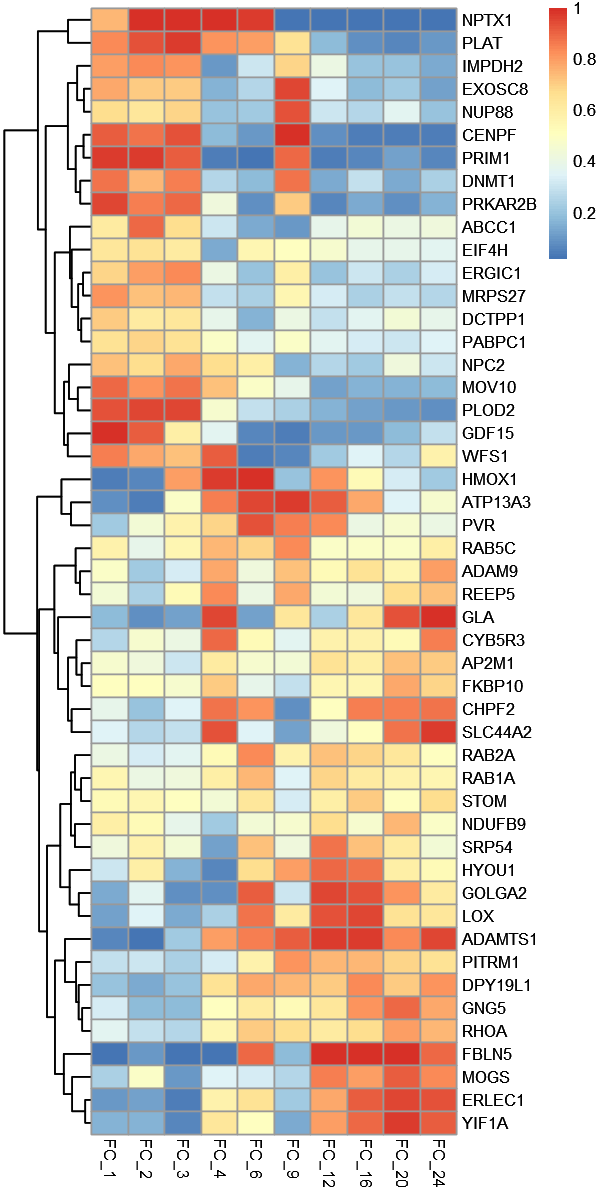

In [10]:
options(repr.plot.width=5, repr.plot.height=10)
Data <- covid[,c(1,93:134), with = FALSE]
DATA_matrix <- heatmapNormalize(Data)
p <- pheatmap(percentize(DATA_matrix), cluster_row = TRUE, cluster_cols = FALSE, show_rownames = TRUE);p
#tiff(file = "./results/4 shear heatmap normalized.tiff", width = 2000, height = 5300, units = "px", res = 400);p;dev.off()

### Expand the network to SARS-CoV-2 indirect binding partners. String and Cytoscape were used to infer proteins that are likely to be effected by the primary protein-protein interaction.

In [12]:
cyto <- fread(cytofile);cyto <- cyto[!grep("SARS", Node),]
#### pull out COVID-19 interacting proteins ####
covidcyto <- final_covid[(final_covid$GeneName %in% cyto$interact),]
#### separate into PSOS or shear responsive ####
covidcyto_shear <- covidcyto[covidcyto$shear_responsive == "pattern_independent",]
covidcyto_psos <- covidcyto[covidcyto$PSOS_responsive == "PSOS",]
#### remove duplications ####
covidcyto_sheardup <-covidcyto_shear[covidcyto_shear[, .I[which.min(`FDRscore_shear`)], by=GeneName]$V1]
covidcyto_psosdup <-covidcyto_psos[covidcyto_psos[, .I[which.min(`FDRscore_PSOS`)], by=GeneName]$V1]
#### polish genes that were called incorrectly
shear_rm <- c("TRAPPC1", "C19orf48", "SYVN1", "ARHGDIA") #### Genes to remove from shear dataset
psos_rm <- c("NQO1", "DAD1") #### Genes to remove from psos dataset# FBLN5 # 
#### remove genes ####
covidcyto_sheardup <- covidcyto_sheardup[!(covidcyto_sheardup$GeneName %in% shear_rm),]
covidcyto_psosdup <- covidcyto_psosdup[!(covidcyto_psosdup$GeneName %in% psos_rm),]
#### overlapping genes ####
intersect(covidcyto_sheardup$GeneName, covidcyto_psosdup$GeneName)
covid_cyto <- rbind(covidcyto_sheardup, covidcyto_psosdup)
covid_cyto[GeneName == "DAD1"]$PSOS_responsive <- "NA"
#writab(DT=covid_cyto, fname="./results/9 COVID cytoscape interest genes.xls")

character(0)

#### Generate a line graphs of the raw read values of the SARS-CoV-2 indirect interacting shear responsive and PSOS responsive genes

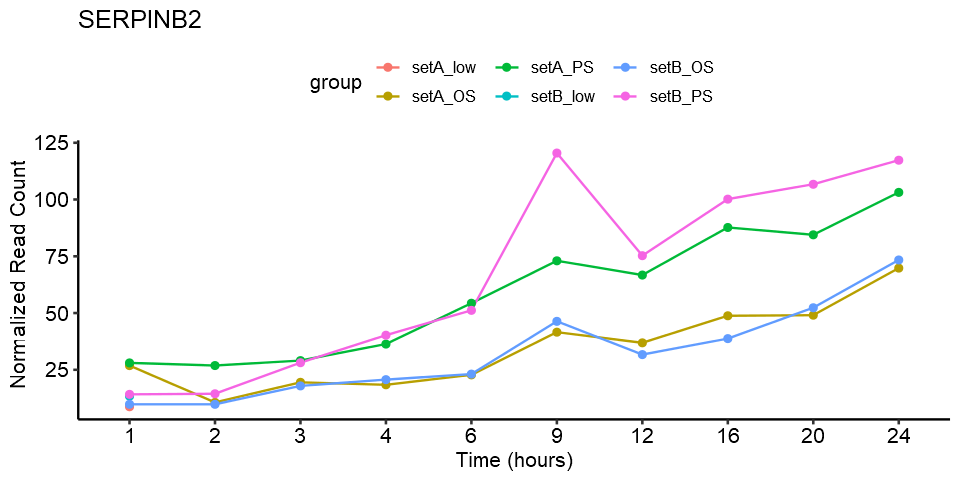

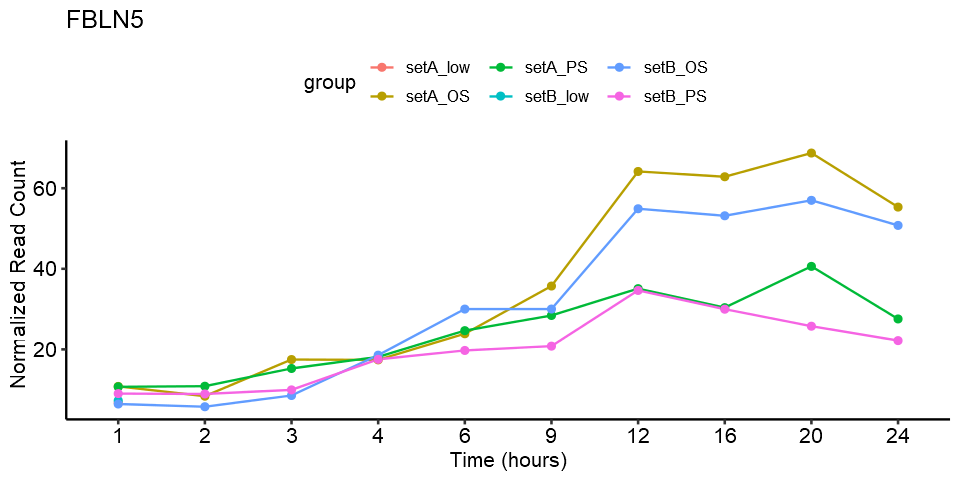

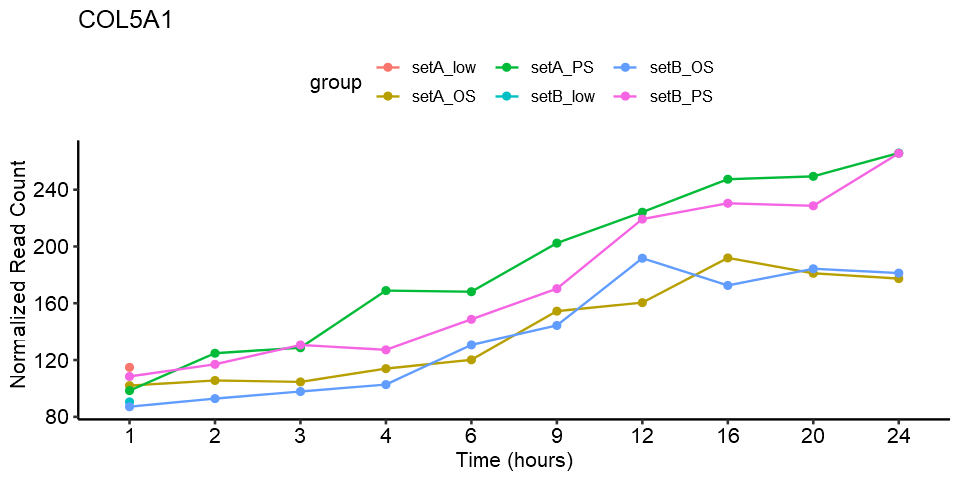

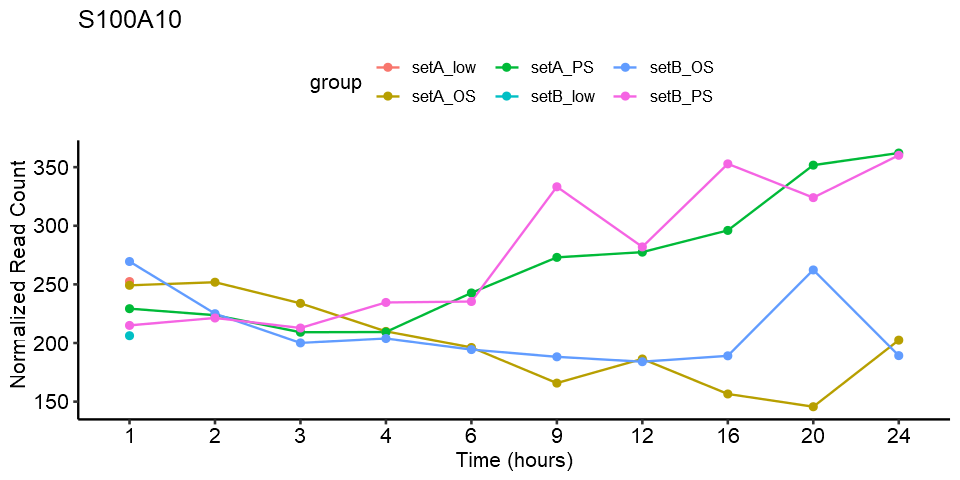

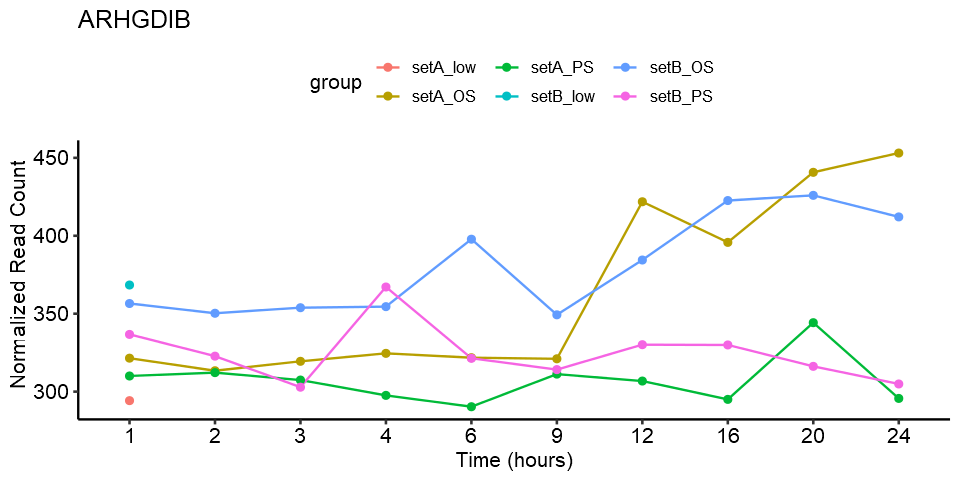

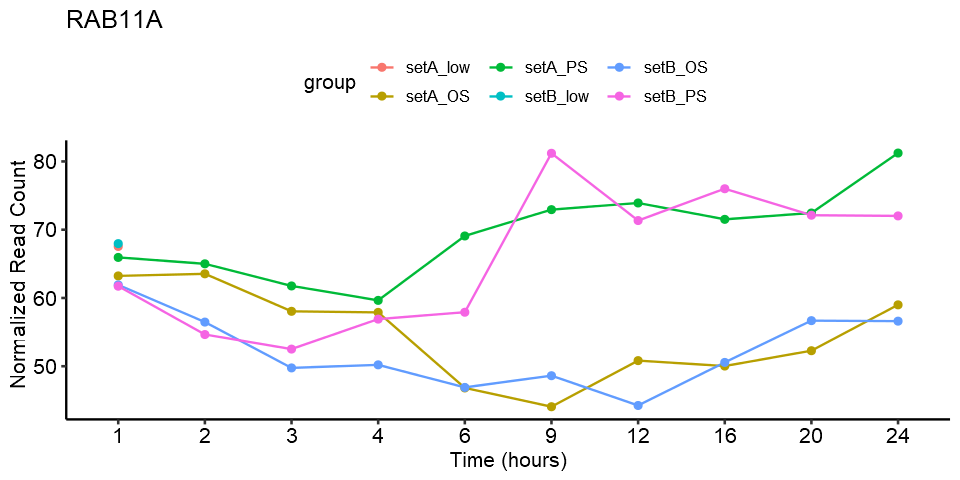

In [22]:
options(repr.plot.width=8, repr.plot.height=4)
for(i in 1:nrow(covid_cyto[PSOS_responsive == "PSOS",])){
print(grapher(covid_cyto[PSOS_responsive == "PSOS",][i,c(1,93:134), with = FALSE]))
}

#### Create a heatmap illustrating the fold changes of genes that respond to flow (PSOS or shear) and are also part of the SARS-CoV-2 interacting network.

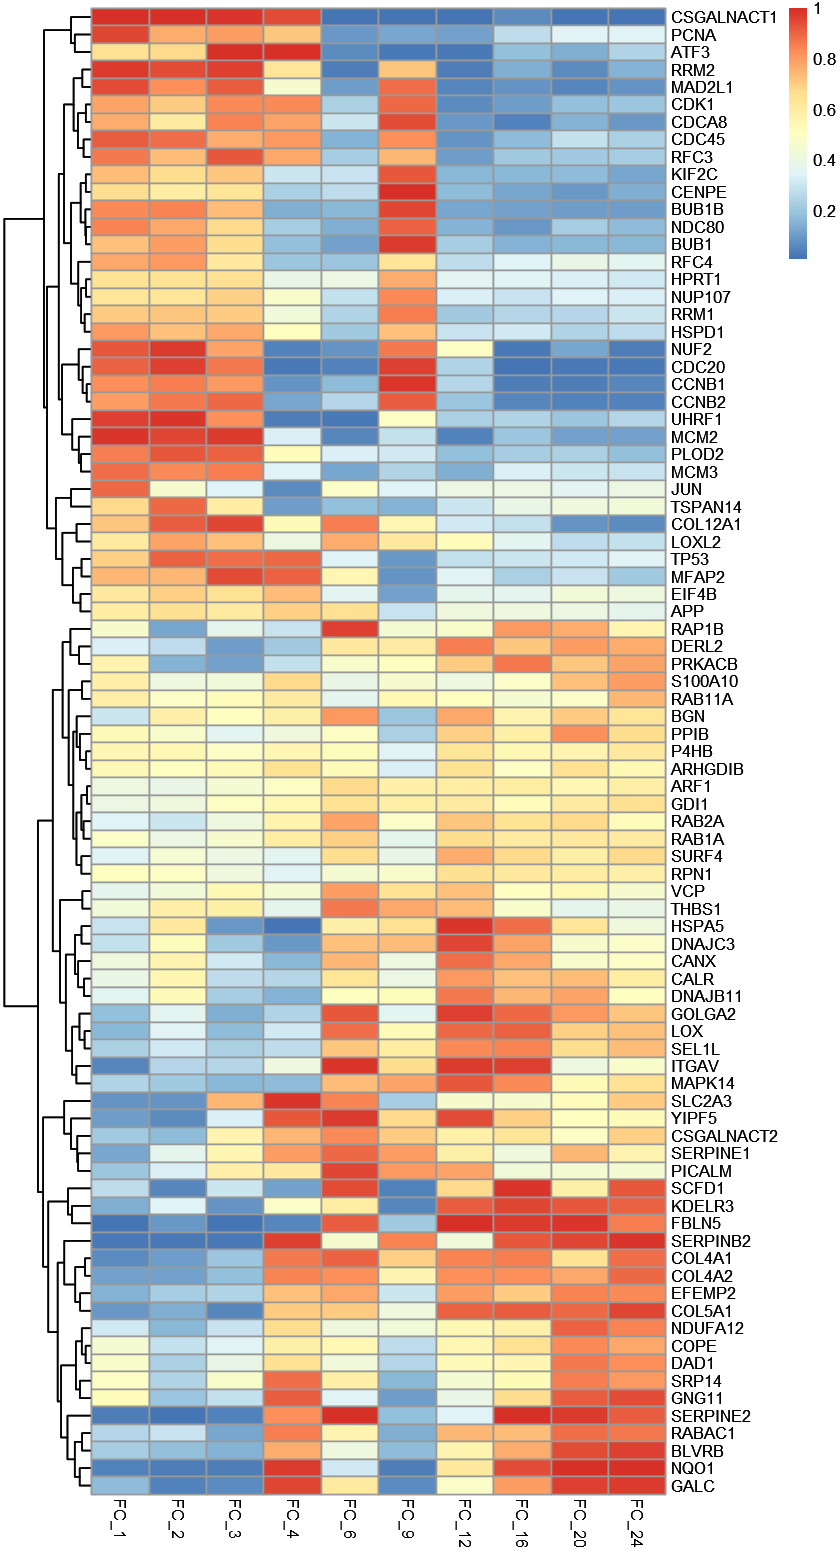

In [23]:
options(repr.plot.width=7, repr.plot.height=13)
Data <- covid_cyto[,c(1,93:134), with = FALSE]
DATA_matrix <- heatmapNormalize(Data)
p <- pheatmap(percentize(DATA_matrix), cluster_row = TRUE, cluster_cols = FALSE, show_rownames = TRUE);p
#tiff(file = "./results/10 COVID cytoscape heatmap normalized.tiff", width = 2000, height = 5300, units = "px", res = 400);p;dev.off()

# Explore the mechanistic basis for how the SARS-CoV-2 interacting network may be differentially regulated and predict kinases that can regulate their activity.

### Identify transcription factor binding sites in the promoters of genes in the SARS-CoV-2 network

#### Compile SARS-CoV-2 interacting proteins and the cytoscape expanded network into a single data.table

In [24]:
DIFsub <- data.table(c(covid$GeneName, covid_cyto$GeneName)) %>% setnames("V1", "wikigene_name")
DIFsub$wikigene_name <- toupper(DIFsub$wikigene_name)
ID2 <- toupper(DIFsub$wikigene_name)

#### Load mRNA sequences for the genes in the SARS-CoV-2 network

In [25]:
# Load the sequence compiled mRNA database
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/bioinformatics/cDNA_transcriptome/2016-3-6 cDNA transcriptomes")
mRNAs <- fread("3 Annotated species mRNA compilation.xls"); setwd(homedir)
mRNAs$external_gene_name <- toupper(mRNAs$external_gene_name)
# Clean data.table
CHR_Labels <- c(1:21, "X", "Y")
TRANS_CHR <- mRNAs[(mRNAs$external_gene_name %in% ID2),] # subset out mRNAs of interest
TRANS_CHR <- TRANS_CHR[(TRANS_CHR$chromosome_name %in% CHR_Labels),] # remove erroneous chromosome labels
TRANS_CHR <- ChromLabel(TRANS_CHR) # relabel chromosome names
TRANS_CHR[1:2,c(1,3:10), with = FALSE]

ensembl_transcript_id,Species_File,Scientific_Name,Common_Name,external_gene_name,transcription_start_site,transcript_start,transcript_end,chromosome_name
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
ENSACAT00000000120,Anolis_carolinensis.AnoCar2.0.cdna.all.fa.gz,Anolis_carolinensis,Lizard,RRM2,148019236,148001345,148019236,chr1
ENSACAT00000001871,Anolis_carolinensis.AnoCar2.0.cdna.all.fa.gz,Anolis_carolinensis,Lizard,DNAJC3,85358907,85358907,85414968,chr3


#### Obtain and clean promoter sequences for genes in the SARS-CoV-2 network

In [26]:
# Load available genomes
ToLoad <- c("Hsapiens.UCSC.hg38","Mmusculus.UCSC.mm10","Rnorvegicus.UCSC.rn6","Btaurus.UCSC.bosTau8","Cfamiliaris.UCSC.canFam3", 
            "Ggallus.UCSC.galGal4","Mmulatta.UCSC.rheMac3","Ptroglodytes.UCSC.panTro3","Sscrofa.UCSC.susScr3")
GenomeLoader(ToLoad)
# return the promoter sequences for the identified transcripts from each Species
genome <- c("Hsapiens.UCSC.hg38","Mmusculus.UCSC.mm10","Rnorvegicus.UCSC.rn6","Btaurus.UCSC.bosTau8", "Cfamiliaris.UCSC.canFam3"
            ,"Ggallus.UCSC.galGal4","Mmulatta.UCSC.rheMac3","Ptroglodytes.UCSC.panTro3","Sscrofa.UCSC.susScr3")
PROMTrans <- ChromosomeSeqCompileR(DT = TRANS_CHR, Spec = genome, distance = 2000)
# Remove sequences that contain a large number of N's 
setnames(PROMTrans, c("ensembl_transcript_id", "Sequence", "Species_File", "Scientific_Name", "Common_Name", "external_gene_name", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Genome_Sequence"),
         c("ensembl_transcript_id", "mRNA_Sequence", "Species_File", "Scientific_Name", "Common_Name", "gene_symbol", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Sequence"))
PROMTrans <- SequenceSiftR(PROMTrans, Percent = 0.50, output = "return_remove")
# Sort out Splice Variants so that the longest transcript of each protein is represented only once in each species
setnames(PROMTrans, c("ensembl_transcript_id", "mRNA_Sequence", "Species_File", "Scientific_Name", "Common_Name", "gene_symbol", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Sequence", "Percent_N"),
         c("ensembl_transcript_id", "Sequence", "Species_File", "Scientific_Name", "Common_Name", "external_gene_name", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Genome_Sequence", "Percent_N"))
PROMTrans <- VariantSort(PROMTrans, variant = "MAX")
PROMTrans[1:2,c(1, 3:10, 12:13), with = FALSE]

  |======================================================================| 100%
  |======================================================================| 100%


ensembl_transcript_id,Species_File,Scientific_Name,Common_Name,external_gene_name,transcription_start_site,transcript_start,transcript_end,chromosome_name,Percent_N,Length
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<int>
ENST00000035307,Homo_sapiens.GRCh38.cdna.all.fa.gz,Homo_sapiens,Human,CHPF2,151232499,151232499,151238827,chr7,0,3978
ENST00000486749,Homo_sapiens.GRCh38.cdna.all.fa.gz,Homo_sapiens,Human,SLC2A3,7936167,7919231,7936167,chr12,0,4414


#### Identify transcription factor binding sites in the promoter sequences for genes in the SARS-CoV-2 network

In [27]:
# Load and annotate the TX_factor data table
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/scripts/transcription factor consensus sequence")
TXDT <- fread("2019-3-22 TX factor data table for R BG.csv", header = TRUE); setwd(homedir)
TXDT <- TXDT[,.(prot, `MotifMap Degenerate consensus sequence`)]
TXDT$prot <- toupper(TXDT$prot)
TXDT$Consensus_Sequence_Medium <- IUPAC_Boolean(TXDT$`MotifMap Degenerate consensus sequence`, stringency = "medium")
setnames(TXDT, c("prot", "MotifMap Degenerate consensus sequence", "Consensus_Sequence_Medium"),
         c("Targeting_Factor", "MotifMap Degenerate consensus sequence", "Consensus_Sequence"))
head(TXDT, 2)
# Perform the transcription factor binding site matches
setnames(PROMTrans, c("ensembl_transcript_id", "Sequence", "Species_File", "Scientific_Name", "Common_Name", "external_gene_name", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Genome_Sequence", "Percent_N", "Length"),
         c("ensembl_transcript_id", "mRNA_Sequence", "Species_File", "Scientific_Name", "Common_Name", "gene_symbol", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Sequence", "Percent_N", "Length"))
TX_TOT_Species <- TFpredict(Target = PROMTrans, Targeting_Factor_DT = TXDT, type = "multiple_species")

Targeting_Factor,MotifMap Degenerate consensus sequence,Consensus_Sequence
<chr>,<chr>,<chr>
AHR,SYYCNRNSTNGCGTGNSW,(G|C)(C|T)(C|T)C.(A|G).(G|C)T.GCGTG.(G|C)(A|T)
AHR,BKNGCGTGHNN,.(G|T).GCGTG...


  |======================================================================| 100%


#### Score, set minimum species conservation cutoff, and count the number of transcription factor binding sites for each promoter sequence

In [31]:
#### Annotate the raw transcription factor hits DT with the IUPAC consensus score
DT25 <- TX_TOT_Species[,c(1:7, 9:12), with = FALSE]
IUPAC <- DT25$`MotifMap Degenerate consensus sequence`
DT25$Score <- IUPAC_ScoreR(IUPAC, stringency = "medium")
#### Retain only transcription factor promoter association conservation between HMR at each promoter 
DT25 <- SpeciesTFCons(DT = DT25,Spec = c("Human", "Mouse", "Rat"), provide = "TF_Target")
writab(DT=DT25, fname="./results/11 HMR Raw Transcription factor hits.xls")
#### Determine the number of times each transcription factor consensus sequence is present for each promoter in human 
TX_ABUN <- TFRankR(DT = DT25, sortBy = "abundance", dec = TRUE); TX_ABUN <- TX_ABUN[TX_ABUN$Species == "Human",]; head(TX_ABUN,3)
#writab(DT=TX_ABUN, fname="./results/12 TX number of consensus sequences Human.xls")

  |======================================================================| 100%


Number_Hits,Targeting_Factor,gene_symbol,Species
<int>,<chr>,<chr>,<chr>
162,BMI1,NPTX1,Human
126,BMI1,GDI1,Human
120,BMI1,ARF1,Human


#### Identify PSOS or shear regulated transcription factors. 

In [33]:
# Annotate the complete data table that is annotated with Shear or PSOS responsiveness, and which proteins interact 
# with SARS-CoV-2 proteins with which genes are also a transcription factor
final_covid$TXfactor <- "NA"
keyTX <- TX_ABUN[!duplicated(TX_ABUN$Targeting_Factor),]$Targeting_Factor
final_covid[(final_covid$GeneName %in% keyTX),]$TXfactor <- "TXfactor"
#### separate into PSOS or shear responsive ####
independent <- final_covid[final_covid$shear_responsive == "pattern_independent" & final_covid$TXfactor == "TXfactor",]
psos <- final_covid[final_covid$PSOS_responsive == "PSOS" & final_covid$TXfactor == "TXfactor",]
#### remove duplications ####
independentdup <-independent[independent[, .I[which.min(`FDRscore_shear`)], by=GeneName]$V1]
psosdup <-psos[psos[, .I[which.min(`FDRscore_PSOS`)], by=GeneName]$V1]
#### overlapping genes ####
intersect(independentdup$GeneName, psosdup$GeneName)
interestTFs <- rbind(independentdup, psosdup)
# polish genes that were called incorrectly ####
shear_rm <- c("NCL") # Genes to remove from shear dataset
shear_to_psos <- c("EPAS1") # Genes to move freom psos dataset to shear dataset
#### remove genes ####
interestTFs[(interestTFs$GeneName %in% shear_rm),]$shear_responsive <- "NA"
#### move genes to proper datatable ####
interestTFs[interestTFs$GeneName == shear_to_psos[1],]$PSOS_responsive <- "PSOS"
interestTFs[interestTFs$GeneName == shear_to_psos[1],]$shear_responsive <- "NA"
#writab(DT=interestTFs, fname="./results/14 covid interest transcription factors.xls")

[1] "EPAS1"

#### Generate a line graphs of the raw read values of the PSOS responsive or shear responsive transcription factors

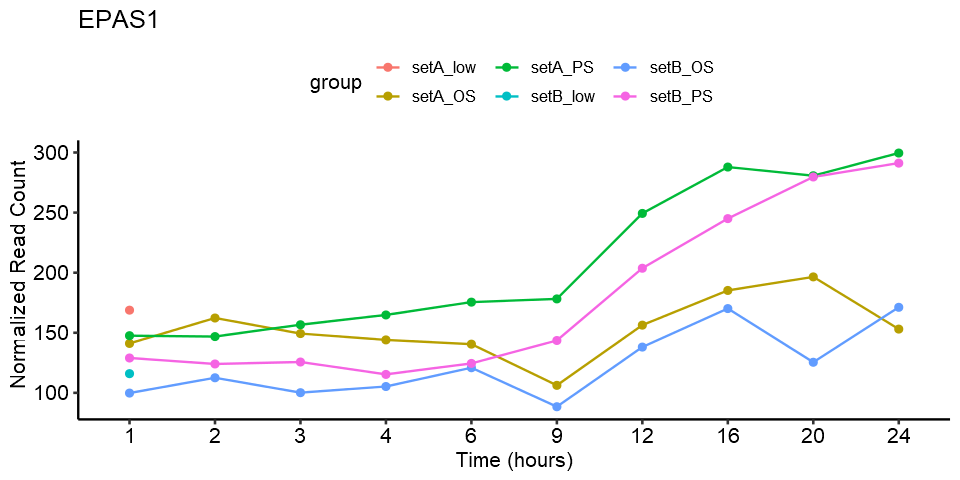

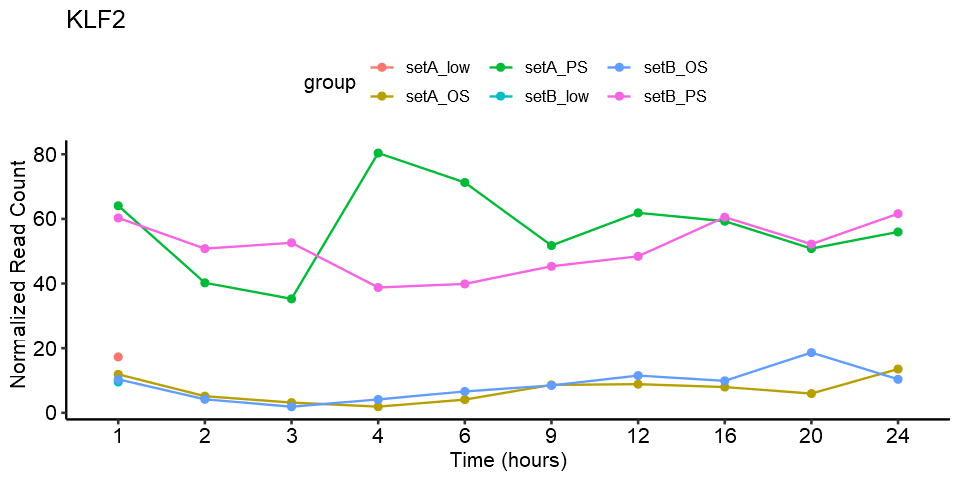

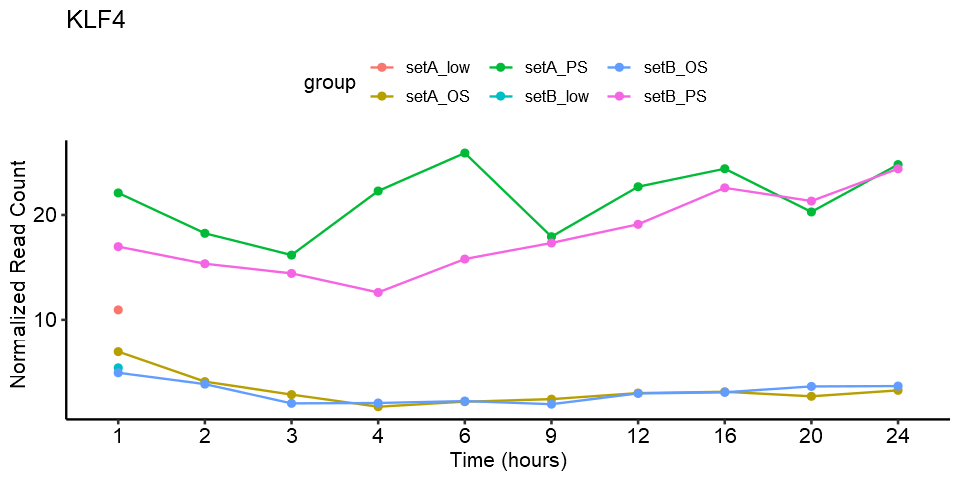

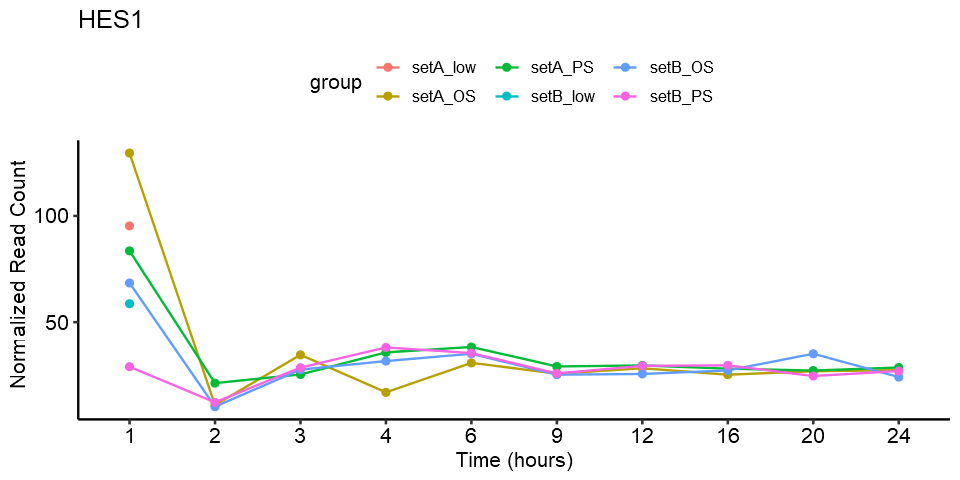

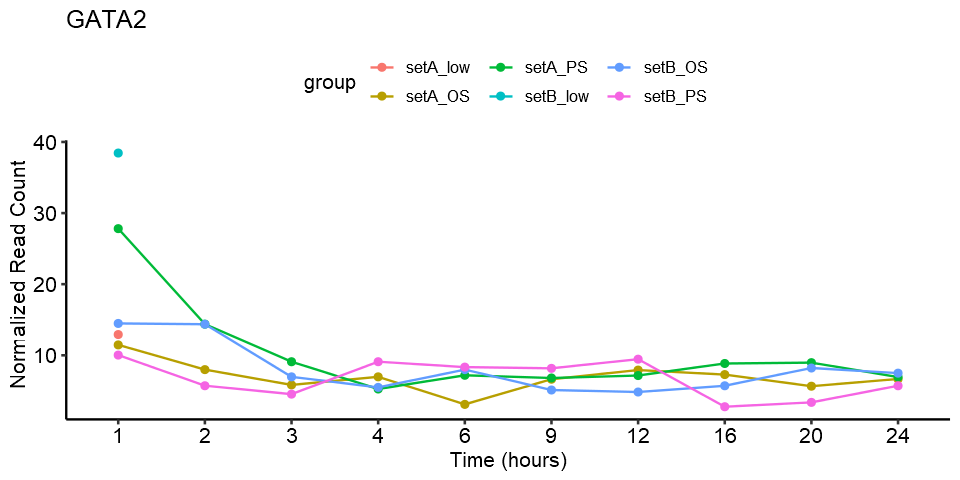

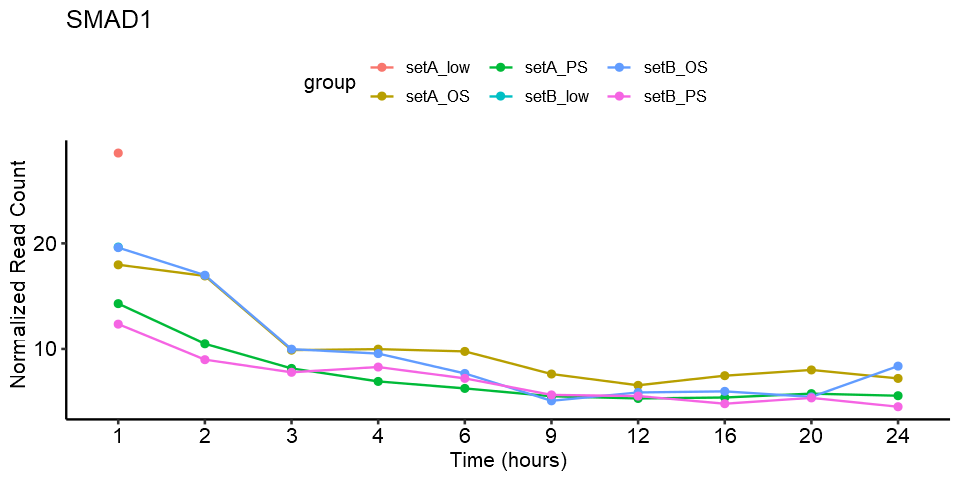

In [34]:
options(repr.plot.width=8, repr.plot.height=4)
for(i in 1:3){
print(grapher(interestTFs[PSOS_responsive == "PSOS",][i,c(1,93:134), with = FALSE]))
}
for(i in 1:3){
print(grapher(interestTFs[shear_responsive == "pattern_independent",][i,c(1,93:134), with = FALSE]))
}

#### Match transcription factors and genes they regulate by their PSOS or shear responsive characteristics

In [35]:
#### Separate transcription factors into PSOS or shear responsive #####
shearTX <- interestTFs[shear_responsive == "pattern_independent",]
psosTX <- interestTFs[PSOS_responsive == "PSOS",]
sheartxkey <- shearTX$GeneName
psostxkey <- psosTX$GeneName
#### compile all COVID-19 genes and separate into PSOS or shear responsive 
intersect(covid_cyto$GeneName, covid$GeneName)
compiledcovid <- rbind(covid_cyto, covid[,c(1:139), with = FALSE])
shear <- compiledcovid[compiledcovid$shear_responsive == "pattern_independent",]
psos <- compiledcovid[compiledcovid$PSOS_responsive == "PSOS",]
shearkey <- shear$GeneName
psoskey <- psos$GeneName

[1] "PLOD2"  "RAB2A"  "LOX"    "GOLGA2" "RAB1A"  "FBLN5"

#### Plot PSOS responsive transcription factors that have binding sites in the promoters of PSOS genes. 

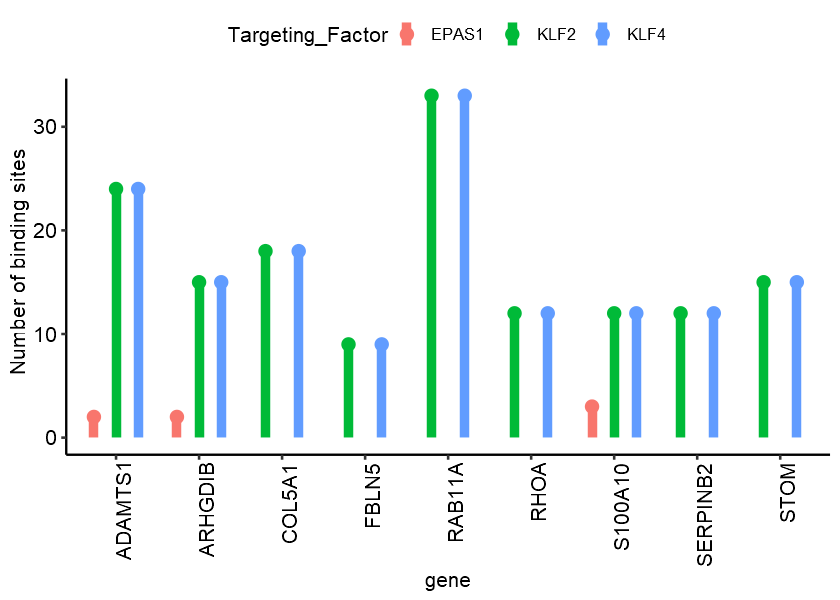

In [36]:
options(repr.plot.width=7, repr.plot.height=5)
hit <- TX_ABUN[(TX_ABUN$Targeting_Factor %in% psostxkey),]; hit <- hit[(hit$gene_symbol %in% psoskey)]
g1 <- ggplot(data=hit, aes(x=gene_symbol, y=Number_Hits, group=Targeting_Factor, colour=Targeting_Factor)) +
  geom_linerange(data=hit, mapping=aes(x=gene_symbol, ymin=0, ymax=Number_Hits), size = 2, position = position_dodge(width = 0.8))+
  geom_point(size = 3, position = position_dodge(width = 0.8)) +
  theme_pubr() +
  ylab("Number of binding sites") +
  xlab("gene") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1));g1
#tiff(file = "./results/15 PSOS tx factor binding sites.tiff", width = 500, height = 500, units = "px", res = 100);g1;dev.off()

#### Plot shear responsive transcription factors that have binding sites in the promoters of shear responsive genes. 

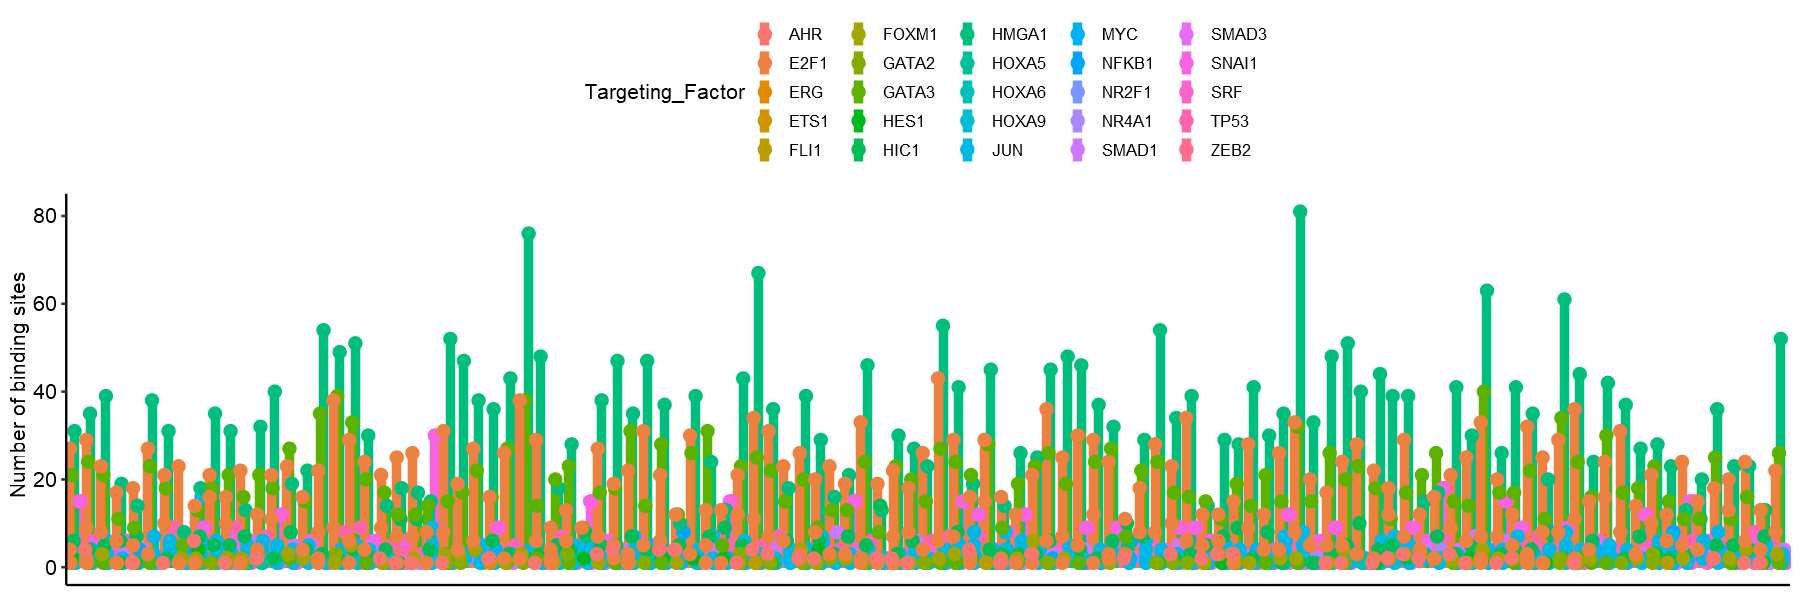

In [37]:
options(repr.plot.width=15, repr.plot.height=5)
hit <- TX_ABUN[(TX_ABUN$Targeting_Factor %in% sheartxkey),]; hit <- hit[(hit$gene_symbol %in% shearkey)]
g1 <- ggplot(data=hit, aes(x=gene_symbol, y=Number_Hits, group=Targeting_Factor, colour=Targeting_Factor)) +
  geom_linerange(data=hit, mapping=aes(x=gene_symbol, ymin=0, ymax=Number_Hits), size = 2, position = position_dodge(width = 0.8))+
  geom_point(size = 3, position = position_dodge(width = 0.8)) +
  theme_pubr() +
  ylab("Number of binding sites") +
  xlab("gene") +
  theme(axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank());g1
#tiff(file = "./results/16 shear tx factor binding sites.tiff", width = 1000, height = 500, units = "px", res = 100);g1;dev.off()

#### Plot the level of expression of the 9 PSOS responsive genes in the KLF4 overexpression RNAseq data set.

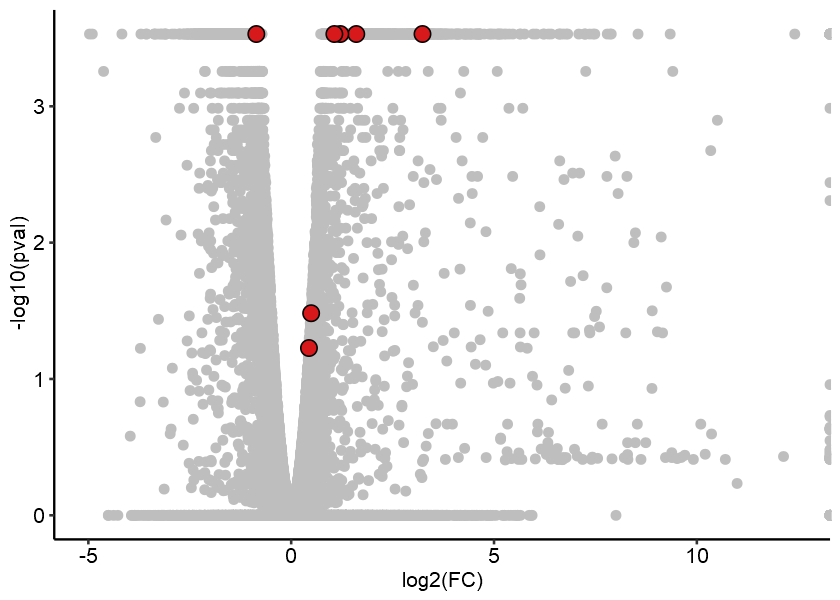

In [38]:
options(repr.plot.width=7, repr.plot.height=5)
DATA <- fread(klf4seq)
DATA$gene <- toupper(DATA$gene)
DATA <- DATA[,c(3,10,13)]
DATA <- DATA[!DATA$`log2(fold_change)` == "#NAME?",]
DATA <- DATA[!DATA$`log2(fold_change)` == "inf",]
DATA$`log2(fold_change)` <- as.numeric(DATA$`log2(fold_change)`)
#### Label all data groups ####
Interactors <- c("ADAMTS1", "ARHGDIB", "COL5A1", "RAB11A",  "S100A10", "SERPINB2", "STOM") # "RHOA", "FBLN5", 
int <- DATA[(DATA$gene %in% Interactors),]
int$group <- "PSOS"
nothing <- DATA[!(DATA$gene %in% Interactors),]
nothing$group <- "All other"
dat <- rbind(int, nothing)
#identical(nrow(DATA), nrow(dat)); nrow(DATA) == nrow(dat)
setnames(dat, colnames(dat), c("gene", "FC", "qval", "group"))
dat$logqval <- -log10(dat$qval) #### Take the -log10 of the q-value
p <- ggplot(dat, aes(x=FC, y=logqval, colour = group)) +
  geom_point(shape = 21, size = 2, colour = "grey", fill = "grey")+
  theme_pubr() +
  labs(x = "log2(FC)", y = "-log10(pval)") +
  geom_point(data = subset(dat, group == 'PSOS'),
             aes(x=FC, y=logqval), shape = 21, size = 4, colour = "black", fill = "#D7191C" );p
#tiff(file = "./results/17 KLF4 overexpression.tiff", width = 500, height = 500, units = "px", res = 100);p;dev.off()

### Identify PS/OS H3K27ac CHiPseq peaks in the 9 PS/OS responsive genes

#### Obtain transcription start sites/chromosome locations 

In [40]:
name <- c("ADAMTS1", "RHOA", "STOM", "SERPINB2", "FBLN5", "COL5A1", "S100A10", "ARHGDIB", "RAB11A")
go <- BioMartR(value = name, 
               mart = "ENSEMBL_MART_ENSEMBL", 
               species = "hsapiens_gene_ensembl", 
               attribute = c("wikigene_name",  "transcription_start_site", "chromosome_name"),
               filter_by = 'wikigene_name')
head(go, 1)
writab(DT=go, fname="./gene_ontology/3 BioMart PSOS transcript information.xls")

wikigene_name,transcription_start_site,chromosome_name
<chr>,<int>,<int>
ADAMTS1,26845409,21


#### Make graphs of the level of H3K27ac flanking the Transcription start site for each PSOS responsive gene 

png 
  2

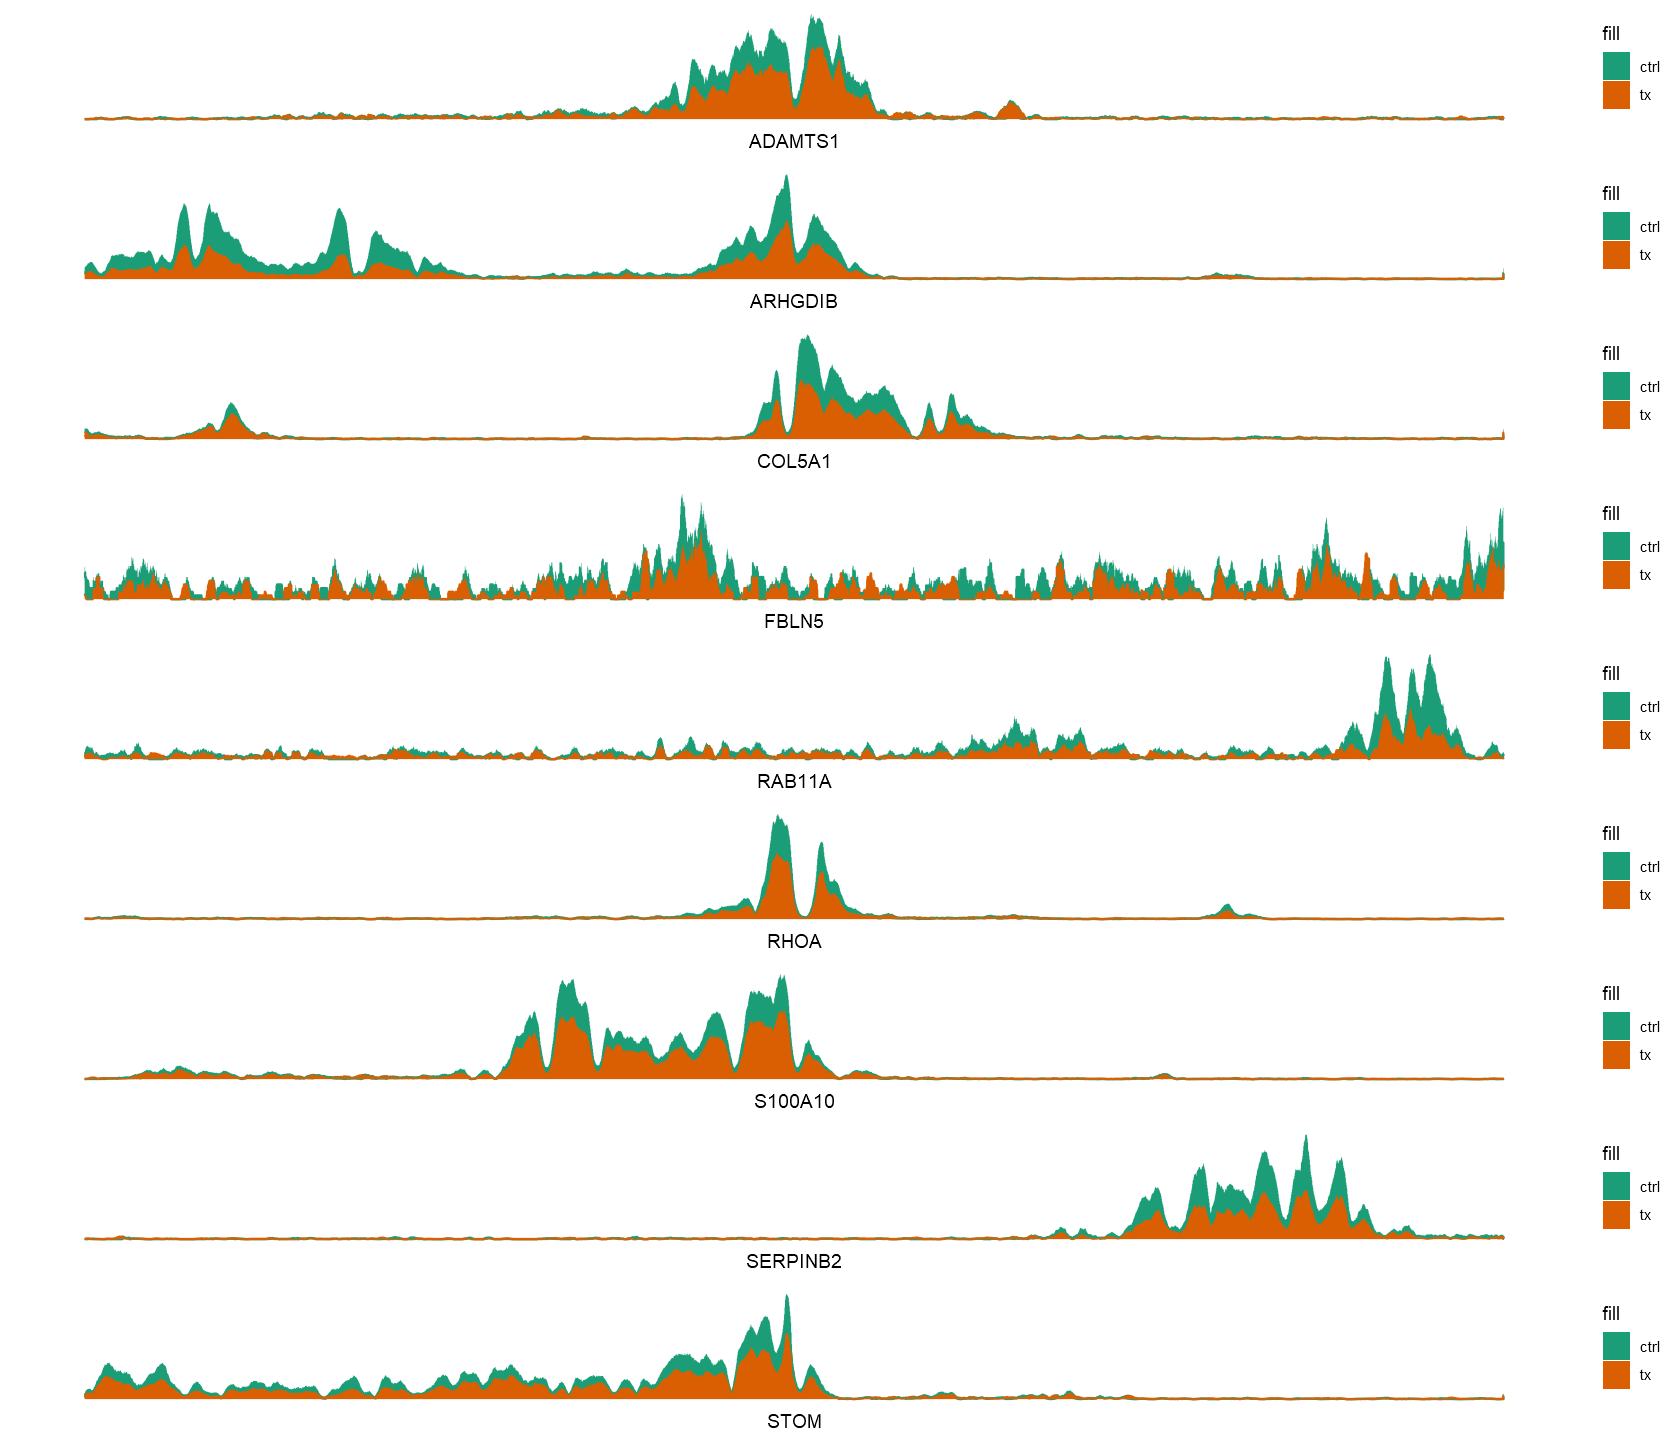

In [41]:
options(repr.plot.width=14, repr.plot.height=12)
go <- go[!duplicated(go$wikigene_name),]
name <- go$wikigene_name
chro <- as.character(go$chromosome_name)
TSS <- go$transcription_start_site
st <- (TSS - 15000)
en <- (TSS + 15000)
PSbw <- "./data/PSOS_H3K27ac/mergebam/merge_bigwig_files/PS.bw"
OSbw <- "./data/PSOS_H3K27ac/mergebam/merge_bigwig_files/OS.bw"

p1 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[1],
                         start <- st[1],
                         end <- en[1],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[1])#;p1
p2 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[2],
                         start <- st[2],
                         end <- en[2],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[2])#;p2
p3 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[3],
                         start <- st[3],
                         end <- en[3],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[3])#;p3
p4 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[4],
                         start <- st[4],
                         end <- en[4],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[4])#;p4
p5 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[5],
                         start <- st[5],
                         end <- en[5],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[5])#;p5
p6 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[6],
                         start <- st[6],
                         end <- en[6],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[6])#;p6
p7 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[7],
                         start <- st[7],
                         end <- en[7],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[7])#;p7
p8 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[8],
                         start <- st[8],
                         end <- en[8],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[8])#;p8
p9 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[9],
                         start <- st[9],
                         end <- en[9],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[9])#;p9

multiplot(p1, p2, p3, p4, p5, p6, p7, p8, p9, cols = 1)
#tiff(file = "./results/18 combined_H3K27ac CHiPseq.tiff", width = 2000, height = 2500, units = "px", res = 300); multiplot(p1, p2, p3, p4, p5, p6, p7, p8, p9, cols = 1);dev.off()

## Identify post translational modification sites in proteins in the SARS-CoV-2 network

#### Obtain and clean protein sequences for genes in the SARS-CoV-2 network

In [42]:
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/bioinformatics/proteomes/2016-4-29 Proteomes") # Windows
PROTan <- fread("3 Annotated species protein compilation.xls"); setwd(homedir)
PROTan$external_gene_name <- toupper(PROTan$external_gene_name)
TRANS_PROT <- PROTan[(PROTan$external_gene_name %in% ID2),]
Sorted_Proteins <- VariantSort(TRANS_PROT, variant = "MAX")
Sorted_Proteins[1:2,c(1, 3:7), with = FALSE]

  |======================================================================| 100%


ensembl_peptide_id,Species_File,Scientific_Name,Common_Name,external_gene_name,Length
<chr>,<chr>,<chr>,<chr>,<chr>,<int>
ENSAMEP00000000043,Ailuropoda_melanoleuca.ailMel1.pep.all.fa.gz,Ailuropoda_melanoleuca,Giant panda,HYOU1,998
ENSAMEP00000000283,Ailuropoda_melanoleuca.ailMel1.pep.all.fa.gz,Ailuropoda_melanoleuca,Giant panda,GDI1,447


#### Identify post translation modification sites in proteins in the SARS-CoV-2 network

In [43]:
# Load and annotate the post translational modification data table
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/bioinformatics/Post translation enzyme data base")
EZDT <- fread("2016-8-22 Post translational enzyme data table for R BG.csv", header = TRUE)
setwd(homedir)
EZDT <- EZDT[,.(Targeting_Factor, Consensus_Sequence)]
head(EZDT,2)
# Perform the moditication site matches
setnames(Sorted_Proteins, colnames(Sorted_Proteins),
         c("ensembl_peptide_id", "Sequence", "Species_File", "Scientific_Name", "Common_Name", "gene_symbol", "Length"))
PROT_TOT_Species <- TFpredict(Sorted_Proteins, EZDT, type = "multiple_species")
PROT_TOT_Species[1:2,c(1:6,8:11), with = FALSE]

Targeting_Factor,Consensus_Sequence
<chr>,<chr>
AMPK,(K|R|H)(F|L|M|I|V)(K|R|H)...(S|T)...(F|L|M|I|V)
AMPK,.(F|L|M|I|V)(K|R|H)...(S|T)...(F|L|M|I|V)


  |======================================================================| 100%


Consensus_Sequence,start,end,Number_Hits,Targeting_Factor,length,Identified_sequence,gene_symbol,Species,Scientific_Name
<chr>,<int>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
(F|I|L|M|V).(R)..(S|T),553,558,1,CaMKIV,998,SlirvesV,HYOU1,Giant panda,Ailuropoda_melanoleuca
(F|I|L|M|V).(R)..(S|T)(F|I|L|M|V),553,559,1,CaMKI,998,SlirvesvF,HYOU1,Giant panda,Ailuropoda_melanoleuca


#### Score, set minimum species conservation cutoff, and count the number of kinase binding sites for each promoter sequence

In [44]:
#### Retain only Posttranslational modification association conservation between for selected species for each protein ##
DT25 <- SpeciesTFCons(DT = PROT_TOT_Species,Spec = c("Human", "Mouse", "Rat"), provide = "TF_Target")
#writab(DT=DT25, fname="./results/19 HMR Raw Posttranslational modification hits.xls")
#### Determine the number of times each Protein consensus sequence is present for each target in human 
TF_ABUN <- TFRankR(DT = DT25, sortBy = "abundance", dec = TRUE)
TF_ABUN <- TF_ABUN[TF_ABUN$Species == "Human",]
head(TF_ABUN, 2)
#writab(DT=TF_ABUN, fname="./results/20 protein number of consensus sequences Human.xls")
#### Determine the number of targets contain a consensus sequence for each posttranslational modifying enzyme in human
TF_PROM <- TFRankR(DT = DT25, sortBy = "Target", dec = TRUE)
TF_PROM <- TF_PROM[TF_PROM$Species == "Human",]
head(TF_PROM, 2)
#writab(DT=TF_PROM, fname="./results/21 protein number of promoters Human.xls")

Number_Hits,Targeting_Factor,gene_symbol,Species
<int>,<chr>,<chr>,<chr>
42,MSK1,DNMT1,Human
42,MSK2,DNMT1,Human


Targeting_Factor,Number_targets,Species
<chr>,<int>,<chr>
AMPK,109,Human
MSK1,99,Human


#### Plot the number of proteins targeted by each kinase

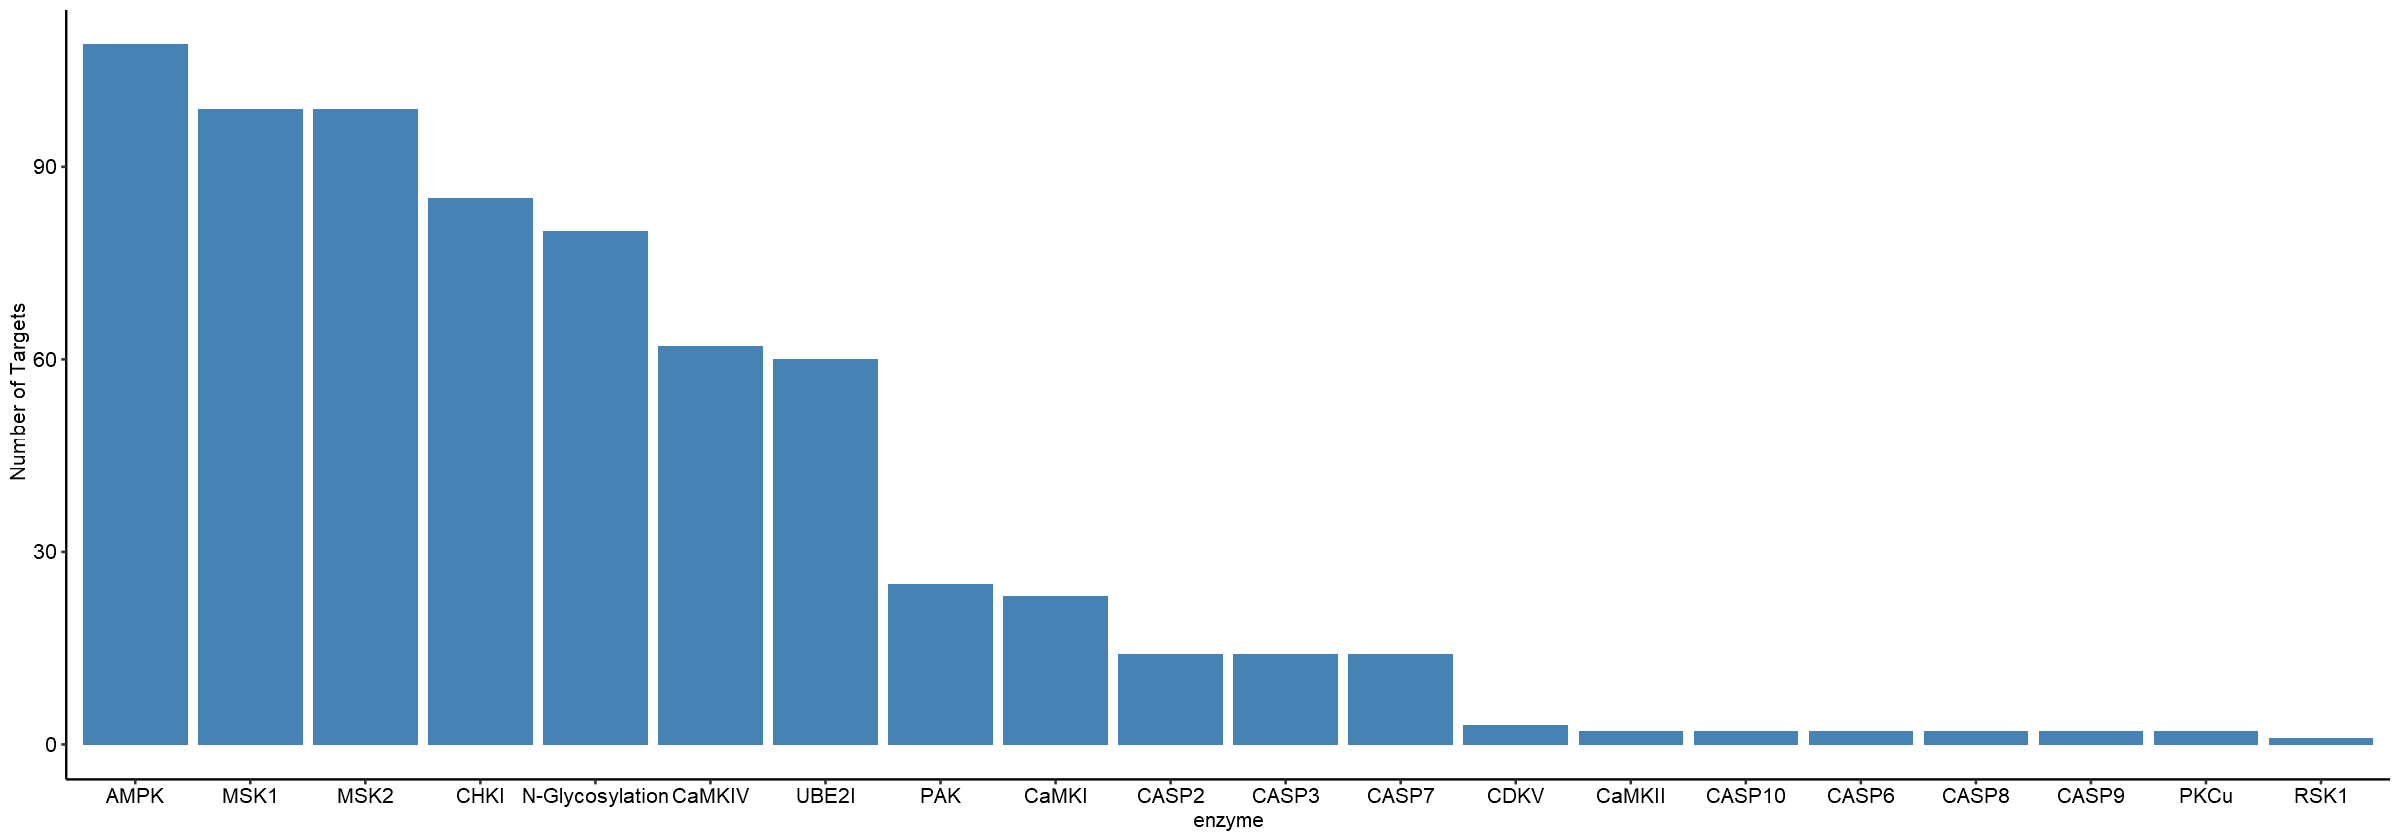

In [45]:
options(repr.plot.width=20, repr.plot.height=7)
g1<-ggplot(data=TF_PROM, aes(x=reorder(`Targeting_Factor`,-Number_targets), y=Number_targets)) +
    geom_bar(stat="identity", fill="steelblue") + theme_pubr()+xlab("enzyme")+ylab("Number of Targets")
g1
#tiff(file = "./results/22 shear kinase number of targets.tiff", width = 2000, height = 500, units = "px", res = 100);g1;dev.off()

#### End of Analysis